# Temporal network from an empirical dataset

## Summary

In this tutorial, we show how to simulate and analyze epidemics on an empirical network whose links have time stamps. We use a network that consists of interactions in a French highschool, see original paper: [*Fournet J, Barrat A. Contact patterns among high school students. PloS one (2014)*](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0107878).


 We downloaded the network from the [SocioPatterns Website](http://www.sociopatterns.org/) and transformed the data to be in the following form:
```
receiving_node source_node time_stamp
```

The network is undirected, so `source` and `receiving` can be swapped.

## Run epidemic

In [1]:
import nextnet as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In the static case \(\psi(\tau)\) represents the distribution of infection times.
In the temporal case, $\psi(\tau)$ only represents the first infection time attempt ('attempt' because the edge might not be there anymore).

In a temporal network characterized by instantaneous contacts, the probability that a transmission occurs is determined by the infectiousness $\lambda(\tau)$ and the weight $w$. $\lambda(\tau)$ is the hazard rate of the infection time distribution $\psi(\tau)$. In formula, the probability $p$ of transmission is given by:
$$p = 1-e^{-w\lambda(\tau)}$$

So, for an exponential distribution $\psi(\tau)=e^{-\lambda_0 \tau}$, the probability of transmission stays constant, unless we included a recovery distribution $\rho(\tau)$

Here, we choose a constant infection time with rate 1, and a constant recovery time with rate 1/7. This implies that a node takes on average $7$ days to recover and spreads the infection to its contacts on average once a day (this last point is a property of the constant rate, in general the time between attempts is more complicated, see our [preprint](https://arxiv.org/abs/2412.07095) for details)

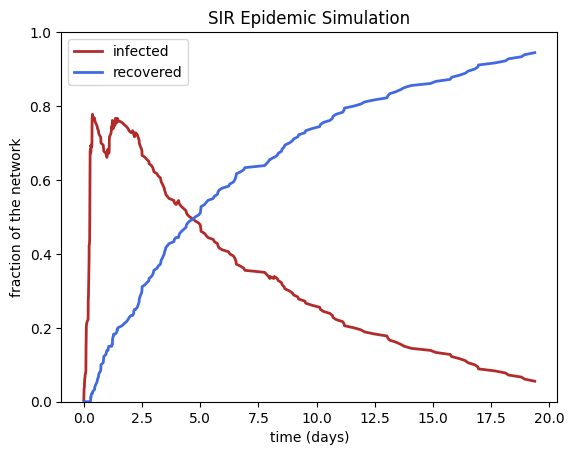

In [2]:
seed=0
rng = nn.rng(seed)

psi = nn.transmission_time_exponential(1)
rho = nn.transmission_time_exponential(1/7)
w=1

g = nn.empirical_contact_network("../assets/data/french_school.csv",
                                finite_duration=False,
                                dt=1, # duration of the link if finite_duration was set to True
                                weight=w)

n = g.nodes() # number of nodes in the network

sim = nn.simulation_temporal(g,psi,rho,SIR=True)

# node 153 is initially infected at time 0
sim.add_infections([(153,0)])

tmax = 20 # force stop condition. Optional. 

opt = {"time": tmax, "network_events":True,"epidemic_events":True} #dictionary of options

results = sim.run(rng,opt) 
# `results` is a dictionnary with four keys: "data","time","infected","recovered".

dark_red = (178/255, 43/255, 43/255)
royal_blue = (65/255, 105/255, 225/255)
plt.plot(results["time"],np.array(results["infected"])/n,lw=2,color=dark_red,label="infected")
plt.plot(results["time"],np.array(results["recovered"])/n,lw=2,color=royal_blue,label="recovered")
plt.xlabel("time (days)")
plt.ylabel("fraction of the network")
plt.ylim([0,1])
plt.legend(loc="upper left")
plt.title("SIR Epidemic Simulation")
plt.show()

We observe that almost everyone gets infected within the first day. The reason is that we used a constant infectiousness. We can repeat the simulation by considering an infection where it takes a few days to become infectious. For example, consider this profile for $\lambda(\tau)$:

## Custom Infectiousness

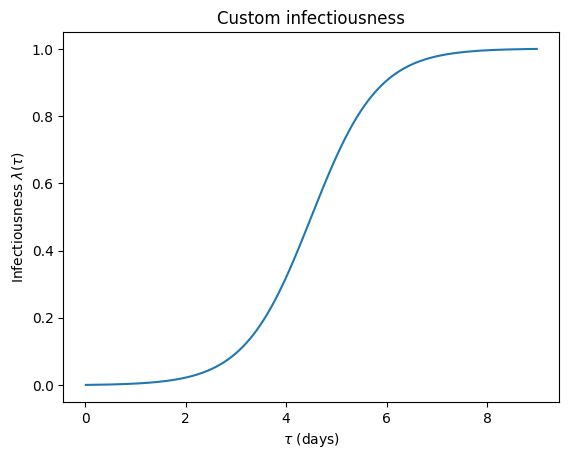

In [3]:
tmax=9
steepness = 1.5

tau = np.arange(0.01,tmax,0.01)
t0 = tmax / 2.0
g = 1.0 / (1.0 + np.exp(-steepness * (tau - t0)))
g0 = 1.0 / (1.0 + np.exp(steepness * t0))
g1 = 1.0 / (1.0 + np.exp(-steepness * t0))
infectiousness = (g - g0) / (g1 - g0)


plt.plot(tau,infectiousness)
plt.xlabel(r'$\tau$ (days)')
plt.ylabel(r'Infectiousness $\lambda(\tau)$')
plt.title("Custom infectiousness")
plt.show()

We run again the simulations with a custom infectiousness. We also increase the weight $w$ to have enough infections


**Important** to run again a simulation, we need to create a new instance of the network!

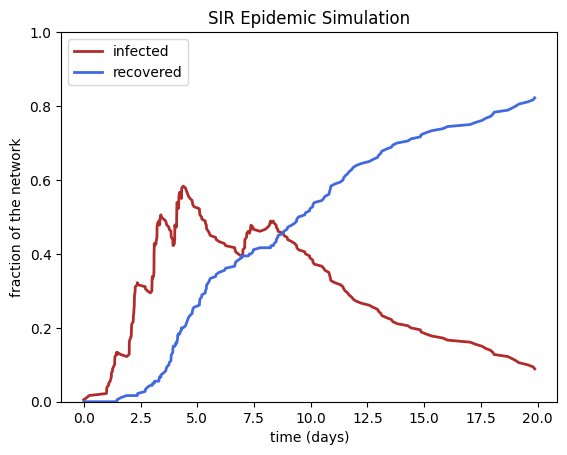

In [4]:
seed=0
rng = nn.rng(seed)

psi = nn.transmission_time_infectiousness(tau,infectiousness)
rho = nn.transmission_time_exponential(1/7)
w=90

g = nn.empirical_contact_network("../assets/data/french_school.csv",
                                finite_duration=False,
                                dt=1, # duration of the link if finite_duration was set to True
                                weight=w)

n = g.nodes() # number of nodes in the network

sim = nn.simulation_temporal(g,psi,rho,SIR=True)

# node 153 is initially infected at time 0
sim.add_infections([(153,0)])

tmax = 20 # force stop condition. Optional. 

opt = {"time": tmax, "network_events":True,"epidemic_events":True} #dictionary of options

results = sim.run(rng,opt) 
# `results` is a dictionnary with four keys: "data","time","infected","recovered".

dark_red = (178/255, 43/255, 43/255)
royal_blue = (65/255, 105/255, 225/255)
plt.plot(results["time"],np.array(results["infected"])/n,lw=2,color=dark_red,label="infected")
plt.plot(results["time"],np.array(results["recovered"])/n,lw=2,color=royal_blue,label="recovered")
plt.xlabel("time (days)")
plt.ylabel("fraction of the network")
plt.ylim([0,1])
plt.legend(loc="upper left")
plt.title("SIR Epidemic Simulation")
plt.show()

## Network Analysis

We can access the full history of the epidemic and the network dynamics. 

In [5]:
df =pd.DataFrame(results["data"])
df.columns = ["time", "receiving node", "source node", "interaction type"]
df = df[df["interaction type"] == 4] #keep only network dynamics
df.head()

,time,receiving node,source node,interaction type
0,0.000000,164,153,4
1,0.000000,153,164,4
3,0.000231,158,153,4
4,0.000231,153,158,4
5,0.003009,164,153,4




("interaction type" :4 represents instanteneous contacts, whereas 0 and 1 represents infection and recovery events.)

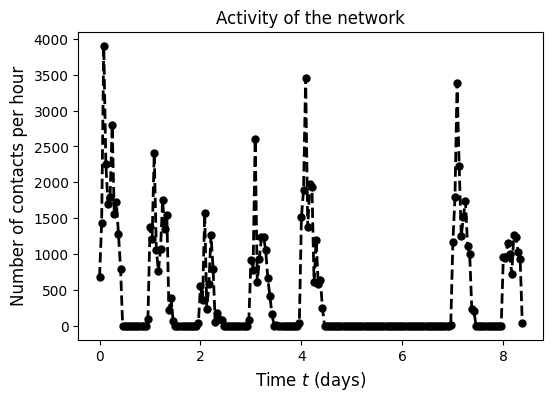

In [6]:
delta_t = 1/24  # bin nb of edges per hour
times = df["time"]

bins = np.arange(times.min(), times.max() + delta_t, delta_t)
counts, edges = np.histogram(times, bins=bins)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(edges[:-2], counts[:-1],'o--',color='black',lw=2,markersize=5)
ax.set_xlabel(r'Time $t$ (days)', fontsize=12)
ax.set_ylabel(r'Number of contacts per hour', fontsize=12)

plt.title("Activity of the network")
plt.show()

## Computing many trajectories

For example, we want to compute the average fraction of recovered given a weight $w$.

In [7]:
nb_sim = 10
n=180 # number of nodes in the network

seed=0
rng = nn.rng(seed)

psi = nn.transmission_time_infectiousness(tau,infectiousness)
rho = nn.transmission_time_exponential(1/5)
rho = nn.transmission_time_gamma(5,1)
opt = {"network_events":False,"epidemic_events":True} #dictionary of options

# Range of weight w values
w_values = np.arange(0, 30, 3)

means = []
stds = []

for w in w_values:
	results = []

	for repeat in range(nb_sim):

		g = nn.empirical_contact_network("../assets/data/french_school.csv",
                                finite_duration=False,
                                dt=1, # duration of the link if finite_duration was set to True
                                weight=w)

		sim = nn.simulation_temporal(g, psi,rho,SIR=True)
		random_node = np.random.randint(0,n)
		sim.add_infections([(random_node,0)])
		res = sim.run(rng,opt)
		frac_rec = res["recovered"][-1] / n # fraction of recovered
		results.append(frac_rec)

	# compute statistics
	means.append(np.mean(results))
	stds.append(np.std(results, ddof=1))  # use sample std

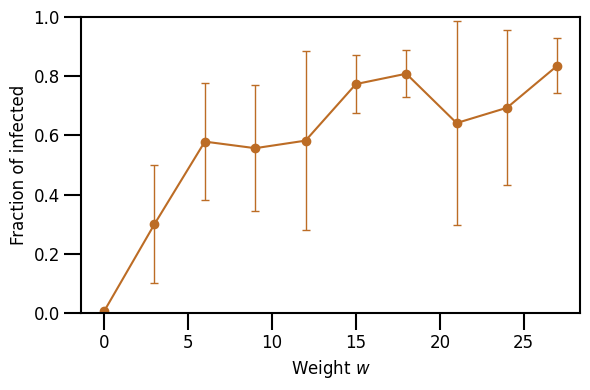

In [ ]:

eastern_blue =(43/255, 177/255, 177/255)
burnt_orange    = (188/255, 108/255, 37/255)  # "#bc6c25"

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(w_values, means,yerr=stds, fmt='-o', elinewidth=1, capsize=3,color=burnt_orange,label="Constant infectiousness")
ax.set_xlabel(r'Weight $w$', fontsize=12)
ax.set_ylabel(r'Fraction of infected', fontsize=12)

# Make the frame thicker
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)

# Make the major ticks longer
ax.tick_params(axis='y', which='major', length=12, width=1.5)
ax.tick_params(axis='x', which='major', length=12, width=1.5)

# Make the minor ticks longer
ax.tick_params(axis='y', which='minor', length=10, width=1.5)
ax.tick_params(axis='x', which='minor', length=10, width=1.5)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# ax.set_xscale("log")

# ax.set_xlim([0,0.4])
ax.set_ylim([0,1])
plt.title("")
plt.tight_layout()
plt.show()